In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import warnings
import torch
import numpy as np
import random

warnings.filterwarnings("ignore")

sys.path.append("../")


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed = 42
fix_seed(seed)

In [2]:
from FL_utils import *
from FL_model import SupervisedContrastiveLoss, create_encoder, add_projection_head, create_decoder, create_vae_encoder, Sampling
from FL_model import create_clf_head, CL_training                                       
from FL_evaluation import *

2024-01-17 14:39:10.755194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 14:39:11.358008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-17 14:39:11.358064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-17 14:39:11.358070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
mimic_dir = r'/media/nghia/DATA/DATA/MIMICIII_Grouped'

exclude_var_list = ['icustay_id', 'label_death_icu']

train_data_mimic, train_target_mimic = get_data(mimic_dir, 'train_24h(min24h).csv',
                                                exclude_var_list=exclude_var_list, outcome_var='label_death_icu')
test_data_mimic, test_target_mimic = get_data(mimic_dir, 'test_24h(min24h).csv',
                                                exclude_var_list=exclude_var_list, outcome_var='label_death_icu')

train_data_mimic.shape, train_target_mimic.shape

((14624, 23), (14624,))

In [4]:
train_data_mimic_list = []
train_target_mimic_list = []
num_clients = 9

for i in range(num_clients):
    train_data_mimic_list.append(train_data_mimic.iloc[int(i*len(train_data_mimic)/num_clients):int((i+1)*len(train_data_mimic)/num_clients)])
    train_target_mimic_list.append(train_target_mimic.iloc[int(i*len(train_target_mimic)/num_clients):int((i+1)*len(train_target_mimic)/num_clients)])

for i in range(num_clients):
    globals()[f'client_data_{i}'] = pd.DataFrame(train_data_mimic_list[i])
    globals()[f'client_target_{i}'] = pd.DataFrame(train_target_mimic_list[i])

client_data_0.shape, client_target_0.shape

((1624, 23), (1624, 1))

In [5]:
input_shape = (23,)
latent_dim = 16
hidden_units = [128, 64, 32]
epsilon = 1e-7

In [6]:
num_rounds = 10
weight_dir = "CL_weights_9Clients"

client_data_list = [client_data_0, client_data_1, client_data_2, client_data_3, client_data_4,
                    client_data_5, client_data_6, client_data_7, client_data_8]
client_target_list = [client_target_0, client_target_1, client_target_2, client_target_3, client_target_4,
                      client_target_5, client_target_6, client_target_7, client_target_8]

In [7]:
global_clf = CL_training(create_clf_head(input_shape), client_data_list,
                         client_target_list, weight_dir, 32, 10)

start data concatenation
start training
Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
  1/457 [..............................] - ETA: 9:48 - loss: 120.6481 - accuracy: 0.1562 - f1_metric: 0.0422 - precision_metric: 0.0244 - recall_metric: 0.1562

2024-01-17 14:39:15.063425: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-17 14:39:15.064506: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-17 14:39:15.064516: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-01-17 14:39:15.112442: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptx

457/457 [==============================] - 4s 6ms/step - loss: 15.3729 - accuracy: 0.7192 - f1_metric: 0.7486 - precision_metric: 0.8558 - recall_metric: 0.7192
Epoch 2/10
457/457 [==============================] - 3s 6ms/step - loss: 1.5224 - accuracy: 0.9150 - f1_metric: 0.9177 - precision_metric: 0.9228 - recall_metric: 0.9150
Epoch 3/10
457/457 [==============================] - 3s 6ms/step - loss: 0.5928 - accuracy: 0.9300 - f1_metric: 0.9242 - precision_metric: 0.9202 - recall_metric: 0.9300
Epoch 4/10
457/457 [==============================] - 3s 6ms/step - loss: 0.3409 - accuracy: 0.9433 - f1_metric: 0.9294 - precision_metric: 0.9174 - recall_metric: 0.9433
Epoch 5/10
457/457 [==============================] - 3s 5ms/step - loss: 0.2679 - accuracy: 0.9494 - f1_metric: 0.9325 - precision_metric: 0.9173 - recall_metric: 0.9494
Epoch 6/10
457/457 [==============================] - 3s 6ms/step - loss: 0.2414 - accuracy: 0.9514 - f1_metric: 0.9333 - precision_metric: 0.9171 - recall

In [8]:
y_pred_global, y_label_global = get_predictions(global_clf, test_data_mimic)

evaluation(test_target_mimic, y_label_global, y_pred_global)

115/115 [==============================] - 0s 598us/step
Accuracy:  0.9559748427672956
Precision:  0.9138879000039555
Recall:  0.9559748427672956
F1 score:  0.9344577241198002
AUC:  0.8179321176286654
Average precision score:  0.2311472243032169


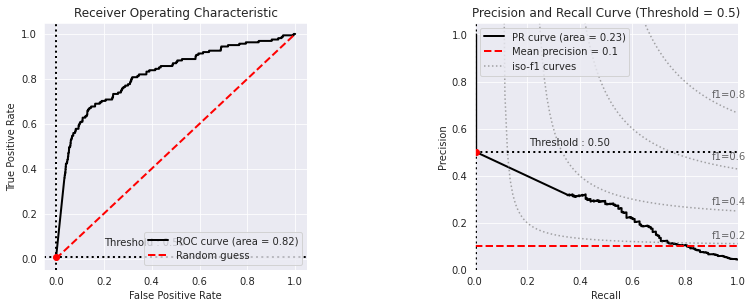

f1 score 0.1771:
f2 score 0.3360:
precision 0.9139:
recall 0.9560:
AUPRC 0.2622:
AUROC 0.8179:
Acc 0.9560:
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3496
           1       0.50      0.01      0.01       161

    accuracy                           0.96      3657
   macro avg       0.73      0.50      0.49      3657
weighted avg       0.94      0.96      0.93      3657



In [9]:
bnr_rp(test_target_mimic, y_pred_global, y_label_global, labels=[0, 1])